In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
import random
from scipy.spatial.distance import cdist
%matplotlib inline

## Generate fake data

In [140]:
from sklearn.datasets import make_blobs
# Create Data
data, labels = make_blobs(n_samples=100, n_features=2, 
                           centers=2, cluster_std=2., random_state=100)
x = data[:,0]
y = data[:,1]

### Visualize

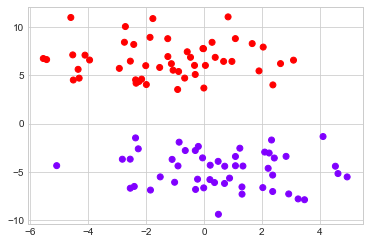

In [141]:
sns.set_style("whitegrid")
plt.scatter(x , y, c = labels, cmap='rainbow')

### Now, lets apply Scikit-lear's EM GMM for binary classification

In [142]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.mixture import GaussianMixture               

In [143]:
n_centroids = 2

In [144]:
gm = GaussianMixture(n_components=n_centroids,
                     random_state=100,
                     n_init=1,
                     max_iter=100)
gm.fit(data)
gm_labels = gm.predict(data)

print(confusion_matrix(labels, gm_labels))
print(classification_report(labels, gm_labels))

[[50  0]
 [ 0 50]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00        50

avg / total       1.00      1.00      1.00       100



In [145]:
[[x_cen1, y_cen1],[x_cen2, y_cen2]] = gm.means_

## Plot with predicted labels

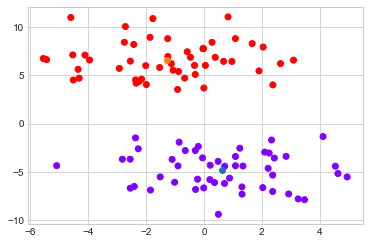

In [146]:
sns.set_style("whitegrid")
plt.scatter(x , y, c = gm_labels, cmap='rainbow')
plt.scatter(x_cen1,y_cen1,cmap='rainbow')
plt.scatter(x_cen2,y_cen2)

## Let's write a code for EM GMM

In [147]:
steps = 100
x_cen1, y_cen1 = [10,1] #data[0][random_index]
x_cen2, y_cen2 = [1,1] #data[0][random_index] + [1,-8]

In [148]:

for i in range(steps):    
    
    #calculate distances from each centroid to all data points
    dist1 = (x - x_cen1)**2 + (y - y_cen1)**2 
    dist2 = (x - x_cen2)**2 + (y - y_cen2)**2     
   
    # calculate stds
    std1 = np.std(np.sqrt(dist1))
    std2 = np.std(np.sqrt(dist2))
    
    #Expectation part: estimate gaussian likelihood
    p1 = (1 / (std1*np.sqrt(2*np.pi))) * np.exp((-1.0* dist1)/(2 * std1))
    p2 = (1 / (std1*np.sqrt(2*np.pi))) * np.exp((-1.0* dist2)/(2 * std2))
    ex1 = p1 / sum(p1)
    ex2 = p2 / sum(p2)
    
    #maximization part: recalculate centers
    x_cen1, y_cen1 = np.sum(np.dot(x,ex1)) , np.sum(np.dot(y,ex1)) 
    x_cen2, y_cen2 = np.sum(np.dot(x,ex2)) , np.sum(np.dot(y,ex2)) 

#np.array([[x_cen1,y_cen1],[x_cen2,y_cen2]])
       

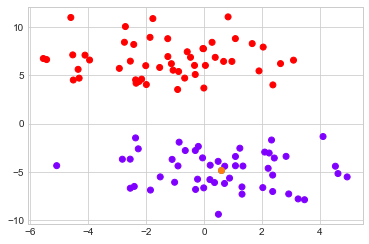

In [149]:
sns.set_style("whitegrid")
plt.scatter(data[:,0],data[:,1],c=labels,cmap='rainbow')
plt.scatter(x_cen1,y_cen1,cmap='rainbow')
plt.scatter(x_cen2,y_cen2)


## Scalable and vectorized

In [150]:
cents = np.array([[10,1],[1,1]])
#np.random.uniform()
len(cents)

2

In [151]:
data.max(axis=0)

array([  4.93731396,  11.05094711])

In [152]:
a = np.random.rand(3, 2)
a

array([[ 0.02238244,  0.2610483 ],
       [ 0.42803537,  0.10692638],
       [ 0.29825427,  0.09248333]])

In [153]:
a * data.max(axis=0).T

array([[ 0.11050915,  2.8848309 ],
       [ 2.11334499,  1.18163782],
       [ 1.47257496,  1.02202835]])

In [154]:
def Initilize_centroids(x_inp, n_centroids):
    '''
    Initilize centroids by randomly selecting from data range.
    
    -----------
    
    Input:   x_inp - numpy ndarray of dimension (n_samples, n_features)
             n_centroind  - number of components( means or centroids )
    Output:  init_means - numpy ndarray of dimension (n_centroids, n_features)
    '''
    x_max, x_min  = x_inp.max(axis=0), x_inp.min(axis=0)
    n_features = x_inp.shape[1]
    init_means = np.random.rand(n_centroids, n_features) * (x_max - x_min) + x_min
    return init_means

In [155]:
from scipy.spatial.distance import cdist

def Estep(x_inp, n_centroids):
    '''
    Performs Expectation step given input data and returns expectation values.   
    
    -----------
    
    Input:   x_inp - numpy ndarray of dimension (n_samples, n_features)
             n_centroind  - number of components( means or centroids )
    Output:  x_expect  - numpy ndarray of dimension (n_samples, n_centroids)
    '''
   
    x_cents = Initilize_centroids(x_inp, n_centroids)   
    dist = cdist(x_inp, x_cents, 'euclidean')
    x_expect = np.empty(shape=[len(x_inp), n_centroids])
    
    for i in range(n_centroids):
        #compute the standard deviations
        std = dist[:,i].std() 
        #Expectation step
        x_expect[:,i] = np.exp((-0.50 * dist[:,i]**2 / std))
        x_expect[:,i] = x_expect[:,i] / x_expect[:,i].sum()
    return x_expect

In [156]:
def Mstep(x_inp, x_expect):
    '''
    Performs Maximization step given input data and expectation values, then
    and returns centroid positions.   
    
    -----------
    
    Input:   x_inp - numpy ndarray of dimension (n_samples, n_features)
             x_expect  - numpy ndarray of dimension (n_samples, n_centroids)
    Output:  means  - numpy ndarray of dimension (n_centroids, n_features)   
    '''
    
    #Maximization Step
    means = np.dot(x_inp.transpose(),x_expect)
    return means.T

In [157]:
def simulate_EM(x_inp, n_centroids, n_steps):
    '''
    Here we simulate EM by iterating up to n_step and return finale centroid positions.   
    
    -----------
    
    Input:   x_inp - numpy ndarray of dimension (n_samples, n_features)
             n_centroind  - number of components( means or centroids )
    Output:  means  - numpy ndarray of dimension (n_centroids, n_features)
             labels - clustering labels based on finale expectation value comparison  
    '''
    
    for i in range(steps):
        x_expect = Estep(data, n_centroids)
        means = Mstep(data, x_expect)
        
    labels = x_expect.argmax(axis=1) # very elegant way of labeling!
    return means, labels

In [158]:
means , labels = simulate_EM(data, 2, 200)

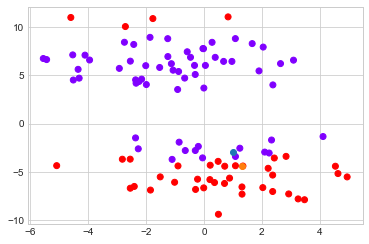

In [159]:

x_cen1, y_cen1 = means[0]
x_cen2, y_cen2 = means[1]
sns.set_style("whitegrid")
plt.scatter(data[:,0],data[:,1],c=labels,cmap='rainbow')
plt.scatter(x_cen1,y_cen1,cmap='rainbow')
plt.scatter(x_cen2,y_cen2)